# Download The Data:
https://figshare.com/articles/dataset/Deep_Image_Reconstruction/7033577?file=14830631
https://figshare.com/articles/dataset/Deep_Image_Reconstruction/7033577?file=14830862

In [147]:
!pip install bdpy

In [148]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import bdpy
import tensorflow as tf

In [149]:
train_bdata = bdpy.BData('../../fMRI data/train_1.h5')
test_bdata = bdpy.BData('../../fMRI data/test_1.h5')
# train_data.show_metadata()

train_data = train_bdata.select("ROI_HVC")
test_data = test_bdata.select("ROI_HVC")

all_data = tf.concat((train_data, test_data), axis=0)


print(train_data.shape)
print(test_data.shape)

(6000, 5066)
(1200, 5066)


In [189]:
dmin, dmax = min(np.min(all_data), np.min(all_data)), max(np.max(all_data), np.max(all_data))
dscale = max(abs(dmin), abs(dmax))
print("dmin: ", dmin, "dmax: ", dmax)
print("dscale: ", dscale)

X = all_data / dscale
X = tf.math.tanh(X)

print("xmin: ", np.min(X), "xmax: ", np.max(X))

dmin:  -241.36007503271463 dmax:  246.3444600442728
dscale:  246.3444600442728
xmin:  -0.7529648519104515 xmax:  0.7615941559557649


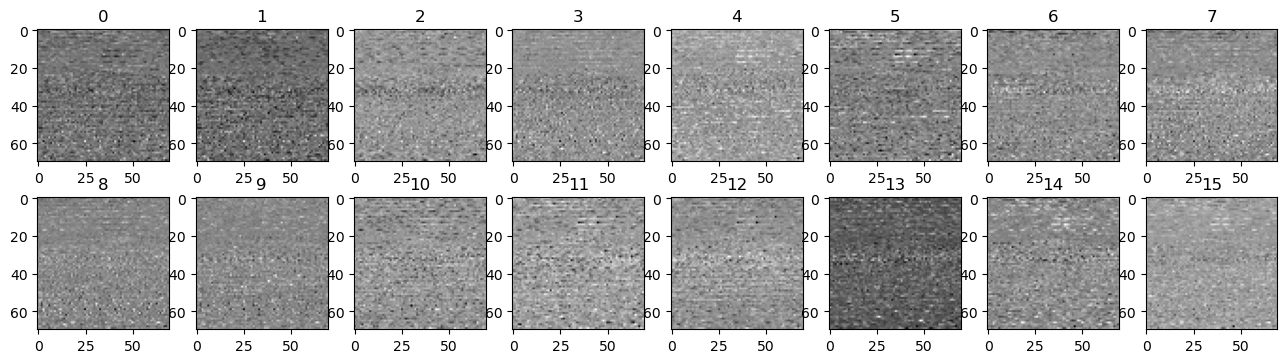

In [190]:
image_samples = np.reshape(X[:, :4900], (-1, 70, 70))

rows = 2
cols = 8
fig, ax = plt.subplots(nrows=rows, ncols=cols)
for r in range(rows):
    for c in range(cols):
        sample_img = image_samples[cols*r + c]
        ax[r][c].imshow((sample_img+1)/2, cmap="gray")
        ax[r][c].set_title(f'{cols*r+c}')

fig.set_size_inches(16, 2*rows)

plt.show()

In [191]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
# from tensorflow.keras.layers import *
# latent_dim = 256

# encoder = tf.keras.Sequential([
#     Input((5066)),
#     Dense(24*24),
#     Reshape((24, 24, 1)),
    
#     Conv2D(32, 2, 2, activation="tanh"),
#     Conv2D(32, 2, 2, activation="tanh"),
#     Conv2D(64, 2, 2, activation="tanh"),
#     Conv2D(64, 2, 1, activation="tanh"),
#     # MaxPool1D(),
#     Flatten(),
#     Dense(2*latent_dim, activation="tanh"),
#     # Dense(2*latent_dim, activation="tanh"),
#     Dense(2*latent_dim),
# ], name = "encoder")

# encoder.summary()

In [194]:
from tensorflow.keras.layers import *
latent_dim = 256

encoder = tf.keras.Sequential([
    Input((5066)),
    Dense(2*latent_dim, activation="tanh"),
    Dense(2*latent_dim),
], name = "encoder")

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 512)               2594304   
_________________________________________________________________
dense_84 (Dense)             (None, 512)               262656    
Total params: 2,856,960
Trainable params: 2,856,960
Non-trainable params: 0
_________________________________________________________________


In [195]:
decoder = tf.keras.Sequential([
    Input((latent_dim)),
    Reshape((latent_dim, 1)),
    Flatten(),
    Dense(2*latent_dim, activation="tanh"),
    Dense(5066, activation="tanh"),
], name = "decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 256, 1)            0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_86 (Dense)             (None, 5066)              2598858   
Total params: 2,730,442
Trainable params: 2,730,442
Non-trainable params: 0
_________________________________________________________________


In [196]:
from autoencoder import VAE
from autoencoder import KL_Callback

kl_beta = tf.Variable(0.0, trainable=False)

vae = VAE(encoder, decoder, kl_beta=kl_beta)
vae.build((None, 5066))
vae.compile(
      optimizer=tf.keras.optimizers.Adam()
)
# vae.summary()

# Train

In [197]:

kl_callback = KL_Callback(kl_beta, 0.001, 0.001, 20)
print(X.shape)
loss = vae.fit(
    X, 
    epochs=100, 
    batch_size=32,
    callbacks=[kl_callback]
)

(7200, 5066)
Epoch 1/100
kl_beta: 0.00100
225/225 [==============================] - 2s 9ms/step - loss: 0.0160 - reconstruction_loss: 0.0062 - kl_loss: 0.1680 - kl_beta: 0.0010
Epoch 2/100
kl_beta: 0.00100
225/225 [==============================] - 2s 10ms/step - loss: 0.0014 - reconstruction_loss: 0.0011 - kl_loss: 0.3195 - kl_beta: 0.0010
Epoch 3/100
kl_beta: 0.00100
225/225 [==============================] - 2s 10ms/step - loss: 0.0013 - reconstruction_loss: 0.0010 - kl_loss: 0.3026 - kl_beta: 0.0010
Epoch 4/100
kl_beta: 0.00100
225/225 [==============================] - 2s 9ms/step - loss: 0.0013 - reconstruction_loss: 9.6226e-04 - kl_loss: 0.2747 - kl_beta: 0.0010
Epoch 5/100
kl_beta: 0.00100
225/225 [==============================] - 2s 10ms/step - loss: 0.0012 - reconstruction_loss: 9.2125e-04 - kl_loss: 0.2405 - kl_beta: 0.0010
Epoch 6/100
kl_beta: 0.00100
225/225 [==============================] - 2s 10ms/step - loss: 0.0011 - reconstruction_loss: 8.7766e-04 - kl_loss: 0.2076

In [180]:
import json
with open('./dense_100e_1e-3.json', 'w') as f:
    json.dump(loss.history, f)


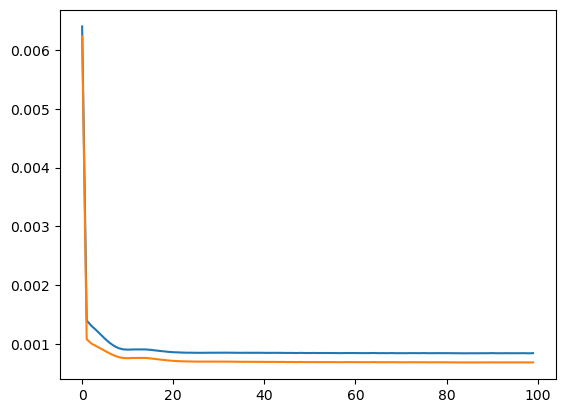

In [198]:
plt.plot(loss.history['loss'])
plt.plot(loss.history['reconstruction_loss'])
# plt.plot(np.array(loss.history['kl_loss']) * np.array(loss.history['kl_beta']))

# Plot Reconstruction

-0.2255970757932964 0.18997213162640977
-0.17564712 0.16227141


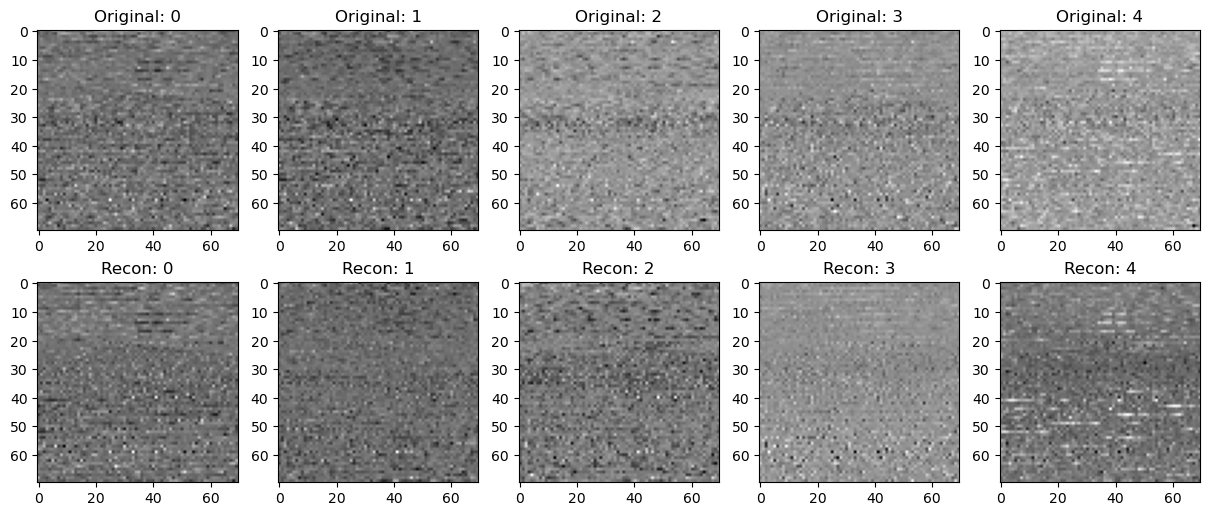

In [199]:
n = 5
start = 0
test_sample = X[start:n+start]
print(np.min(test_sample), np.max(test_sample))

recon = vae(test_sample)
print(np.min(recon), np.max(recon))

fig, ax = plt.subplots(nrows=2, ncols=n)

fig.set_size_inches((3*n, 6))

test_sample = np.reshape(test_sample[:, :4900], (-1, 70, 70, 1))
recon = np.reshape(recon[:, :4900], (-1, 70, 70, 1))

for i in range(n):
  ax[0][i].imshow(test_sample[i], cmap="gray")
  ax[0][i].set_title(f'Original: {i}')
  ax[1][i].imshow(recon[i], cmap="gray")
  ax[1][i].set_title(f'Recon: {i}')

# Save Embeddings

In [202]:
train_embeddings = vae.sample_z(*np.split(vae.encoder(train_data), 2, axis=-1))
test_embeddings = vae.sample_z(*np.split(vae.encoder(test_data), 2, axis=-1))

print(train_embeddings.shape)
print(test_embeddings.shape)

np.save('./train_256.npy', train_embeddings)
np.save('./test_256.npy', test_embeddings)

(6000, 256)
(1200, 256)


# Save Model

In [185]:
import time
t = int(time.time())

vae.save(f'./Trained Models/VAE/trained_vae_model_{t}')

2022-12-11 03:47:34.533395: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Trained Models/VAE/trained_vae_model_1670748454/assets


# Get Embeddings

In [5]:
training_embeddings = model.encoder(train_data)
testing_embeddings = model.encoder(test_data)
print(training_embeddings.shape)
print(testing_embeddings.shape)

(6000, 512)
(1200, 512)


# Load Model

In [4]:
model = tf.keras.models.load_model('./Trained Models/VAE/trained_vae_model_1670286874')